<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp; from scipy.io import wavfile; from scipy import signal
from scipy.signal import windows, freqz
import pydub
from pydub import AudioSegment
import os
import os.path

The sampling rate of the audio files.

In [3]:
sr = 44100
NN = int(2.5*sr)

Little function used to write to audio files.

In [4]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    if os.path.exists(f):
        os.remove(f)
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="441k")

# Get Data

In [5]:
df_a = pd.read_pickle("./acoustic_df.pkl")

In [6]:
E = np.array(df_a['E'].dropna())[0:NN]; Em = np.array(df_a['E_mute'].dropna())[0:NN]; 
A = np.array(df_a['A'].dropna())[0:NN]; Am = np.array(df_a['A_mute'].dropna())[0:NN]; 
D = np.array(df_a['D'].dropna())[0:NN]; Dm = np.array(df_a['D_mute'].dropna())[0:NN]; 
G = np.array(df_a['G'].dropna())[0:NN]; Gm = np.array(df_a['G_mute'].dropna())[0:NN]; 
B = np.array(df_a['B'].dropna())[0:NN]; Bm = np.array(df_a['B_mute'].dropna())[0:NN]; 
Eh = np.array(df_a['Eh'].dropna())[0:NN]; Ehm = np.array(df_a['Eh_mute'].dropna())[0:NN]; 

In [7]:
tt = np.arange(0, len(E), 1)/sr

In [8]:
E_freq = 82.4
A_freq = 110
D_freq = 146.83
G_freq = 196
B_freq = 246.94
Eh_freq = 329.63

# Filtering

Apply a few filters to the time series of the form

$$L[X_t] = \sum_{u=-\infty}^\infty g_u X_{t-u} $$

In [9]:
def remove_mean(arr):
    return np.mean(arr), arr-np.mean(arr)

In [10]:
def apply_filt(arr, g):
    
    new_arr = np.empty(shape=len(arr))
    seq_len = len(g)
    
    for (i, a_i) in enumerate(arr):
        for(j, g_j) in enumerate(g):
            if i-j<0:
                break
            new_arr[i] += g_j*arr[i-j]
    return new_arr

In [11]:
def apply_filt_fast(arr, g):
    return np.convolve(g, arr)[0:len(arr)]


In [12]:
E_mean, E_d = remove_mean(E)
write('modified_sounds/ac_E_demean.mp3', sr, E_d, normalized=False)

## Autoregressive Filter

### Define Impulse Response Sequence $g_u$

Define the autoregressive transfer function. Note we define up to $N$ by zero padding so that the Fourier transform (when computing transfer function) is computed at all the appropriate frequencies.

In [13]:
g_auto1 = np.array([10*np.e**(-((t**2)/25000))+np.sin(t*2*np.pi*2*E_freq/sr) for t in range(5000)])
g_auto1 = g_auto1/np.sum(g_auto1)
g_auto1 = np.concatenate((g_auto1, np.zeros(NN-len(g_auto1))))

g_auto2 = np.array([10*np.e**(-((t**2)/25000))+np.sin(t*3*np.pi*2*E_freq/sr) for t in range(5000)])
g_auto2 = g_auto2/np.sum(g_auto2)
g_auto2 = np.concatenate((g_auto2, np.zeros(NN-len(g_auto2))))

### Get Tranfer Function $|G(f)|^2$

Obtain the Fourier transforms (and then just take the positive portion)

In [14]:
G_auto1 = np.fft.fft(g_auto1)[0:(int(NN/2)+1)]
ff_G_auto1 = np.linspace(0, 1/2, len(G_auto1))*sr

G_auto2 = np.fft.fft(g_auto2)[0:(int(NN/2)+1)]
ff_G_auto2 = np.linspace(0, 1/2, len(G_auto2))*sr

### Plot Impulse Response Sequence and Transfer Function

Plot the transfer functions

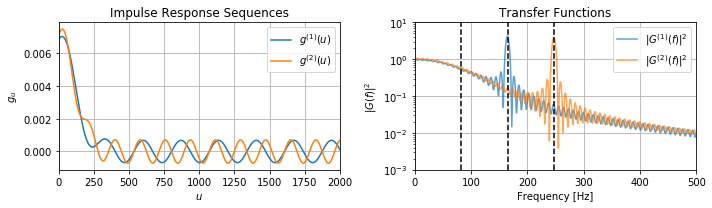

In [15]:
fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(g_auto1, label='$g^{(1)}(u)$')
ax[0].plot(g_auto2, label='$g^{(2)}(u)$')
ax[0].set_xlim(0,2000)
ax[0].set_xlabel('$u$')
ax[0].set_ylabel('$g_u$')
ax[0].set_title('Impulse Response Sequences')
ax[0].grid()
ax[0].legend()

ax[1].semilogy(ff_G_auto1, np.abs(G_auto1)**2, alpha=0.7, label='$|G^{(1)}(f)|^2$')
ax[1].semilogy(ff_G_auto2, np.abs(G_auto2)**2, alpha=0.7, label='$|G^{(2)}(f)|^2$')
ax[1].set_title('Transfer Functions')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('$|G(f)|^2$')
ax[1].set_xlim(0,500)
ax[1].set_ylim(10**-3, 10)
ax[1].grid()
ax[1].axvline(E_freq, color='k', ls='--')
ax[1].axvline(2*E_freq, color='k', ls='--')
ax[1].axvline(3*E_freq, color='k', ls='--')
ax[1].legend()


fig.tight_layout()
plt.savefig('plots/filtering/autofilt.png', dpi=200)

### Apply the Filter

In [16]:
E_autoreg1 = apply_filt_fast(E_d, g_auto1)
E_autoreg2 = apply_filt_fast(E_d, g_auto2)

In [17]:
write('modified_sounds/ac_E_autoreg1.mp3', sr, E_autoreg1, normalized=False)
write('modified_sounds/ac_E_autoreg2.mp3', sr, E_autoreg2, normalized=False)

### Plot Filtered Signal

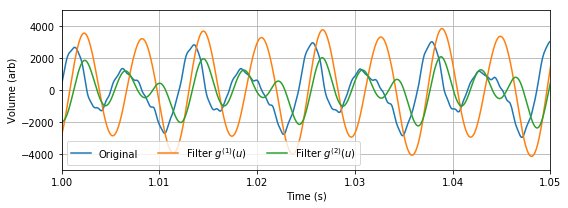

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(tt, E_d, label='Original')
ax.plot(tt, E_autoreg1, label='Filter $g^{(1)}(u)$')
ax.plot(tt, E_autoreg2, label='Filter $g^{(2)}(u)$')
ax.set_xlim(1,1.05)
ax.set_ylim(-5000,5000)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Volume (arb)')
ax.grid()
ax.legend(ncol=3)

fig.tight_layout()
plt.savefig('plots/filtering/autofilt_signal.png', dpi=200)

### Compute periodogram

In [19]:
f_E, Pxx_den_E_d = signal.periodogram(E_d, sr)
f_E_autoreg1, Pxx_den_E_autoreg1 = signal.periodogram(E_autoreg1, sr)
f_E_autoreg2, Pxx_den_E_autoreg2 = signal.periodogram(E_autoreg2, sr)

### Plot periodogram

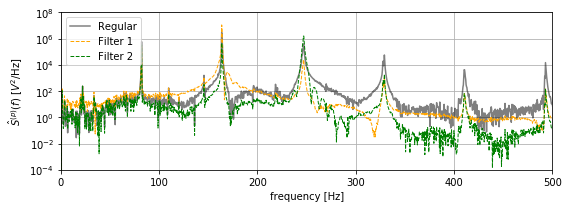

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.semilogy(f_E, Pxx_den_E_d, label='Regular', c='k', alpha=0.5)
ax.semilogy(f_E_autoreg1, Pxx_den_E_autoreg1, label='Filter 1', lw=1, c='Orange', ls='--')
ax.semilogy(f_E_autoreg2, Pxx_den_E_autoreg2, label='Filter 2', lw=1, c='Green', ls='--')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$\hat{S}^{(p)}(f)$ [$V^2$/Hz]')
ax.set_xlim(0,500)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()

fig.tight_layout()
plt.savefig('plots/filtering/autofilt_spec.png', dpi=200)
plt.show()

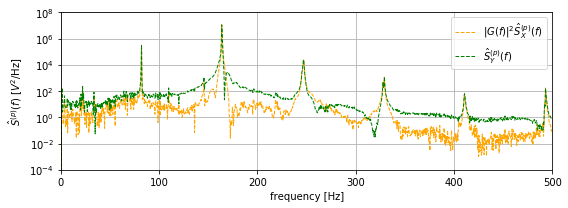

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.semilogy(f_E, Pxx_den_E_d*np.abs(G_auto1)**2, label='$|G(f)|^2 \hat{S}^{(p)}_X(f)$', lw=1, c='Orange', ls='--')
ax.semilogy(f_E_autoreg1, Pxx_den_E_autoreg1, label='$\hat{S}^{(p)}_Y(f)$', lw=1, c='Green', ls='--')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$\hat{S}^{(p)}(f)$ [$V^2$/Hz]')
ax.set_xlim(0,500)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()

fig.tight_layout()
plt.savefig('plots/filtering/show_wrong.png', dpi=200)
plt.show()

Conclusion: The exponentialally decreasing auto-regressive filter is effective for slightly removing power at higher Fourier nodes.

## Least Squares Filter

All filters below will use this value of $K$ (sets number of points able to be used)

In [22]:
K = 1000

### Define the Transfer Function

Define the least squares function (see pg 176-177)

In [23]:
def g_UI(u, W):
    if u==0:
        return 2*W
    else:
        return np.sin(2*np.pi*W*u)/(np.pi*u)

Define various cutoff frequencies.

In [24]:
f1 = 100
f2 = 200
f3 = 510

### Compute the Sequences and Transfer Functions

In [25]:
W=f1/sr
g_lsq1 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])
f_lsq1, G_lsq1 = freqz(g_lsq1, worN=NN)

W=f2/sr
g_lsq2 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])
f_lsq2, G_lsq2 = freqz(g_lsq2, worN=NN)

W=f3/sr
g_lsq3 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])
f_lsq3, G_lsq3 = freqz(g_lsq3, worN=NN)

### Apply filers to the Signal

Apply lowpass filter

In [26]:
E_lsq1 = apply_filt_fast(E_d, g_lsq1)
E_lsq2 = apply_filt_fast(E_d, g_lsq2)
E_lsq3 = apply_filt_fast(E_d, g_lsq3)
write('modified_sounds/ac_E_lsq1.mp3', sr, E_lsq1, normalized=False)
write('modified_sounds/ac_E_lsq2.mp3', sr, E_lsq2, normalized=False)
write('modified_sounds/ac_E_lsq3.mp3', sr, E_lsq3, normalized=False)

### Compute and Plot Periodogram

Compute periodogram for low pass

In [27]:
f_E_lsq1, Pxx_den_E_lsq1 = signal.periodogram(E_lsq1, sr)
f_E_lsq2, Pxx_den_E_lsq2 = signal.periodogram(E_lsq2, sr)
f_E_lsq3, Pxx_den_E_lsq3 = signal.periodogram(E_lsq3, sr)

Plot

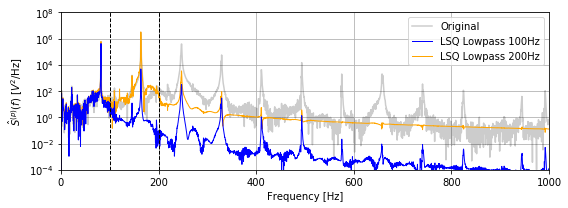

In [42]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.semilogy(f_E, Pxx_den_E_d, label='Original', c='k', alpha=0.2)
ax.semilogy(f_E_lsq2, Pxx_den_E_lsq2, label='LSQ Lowpass 200Hz', lw=1, c='Orange')
ax.semilogy(f_E_lsq1, Pxx_den_E_lsq1, label='LSQ Lowpass 100Hz', lw=1, c='Blue')


ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('$\hat{S}^{(p)}(f)$ [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8)


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax.grid()

# Main Frequencies of a Guitar in Tune
ax.axvline(100, ls='--', color='k', lw=1)
ax.axvline(200, ls='--', color='k', lw=1)

fig.tight_layout()
plt.savefig('plots/filtering/LSQ_comparison.png', dpi=200)
plt.show()

## DPSS Filter

Modify the least squares transfer function to reduce side-lobes (see 181-183).

In [29]:
delta = 0.97
g_dpss1 = windows.dpss(K, delta) * g_lsq1
f_dpss1, G_dpss1 = freqz(g_dpss1, worN=NN)

delta = 0.97
g_dpss2 = windows.dpss(K, delta) * g_lsq2
f_dpss2, G_dpss2 = freqz(g_dpss2, worN=NN)

delta = 0.8
g_dpss3 = windows.dpss(K, delta) * g_lsq3
f_dpss3, G_dpss3 = freqz(g_dpss3, worN=NN)

### Compare DPSS to LSQ Sequence and Response Function

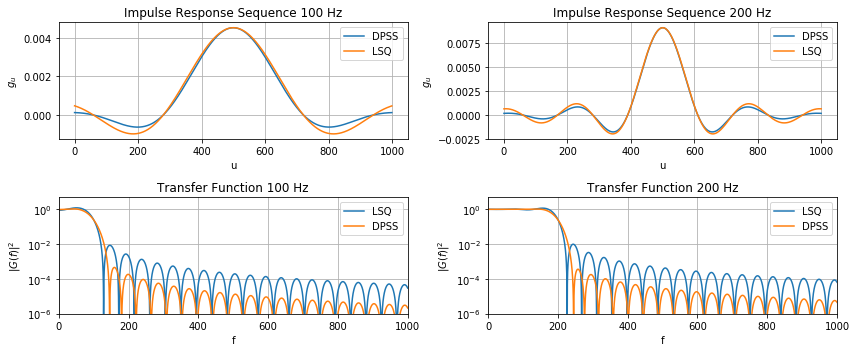

In [30]:
fig, ax = plt.subplots(2,2,figsize=(12,5))

ax[0,0].plot(g_dpss1, label='DPSS')
ax[0,0].plot(g_lsq1, label='LSQ')
ax[0,1].plot(g_dpss2, label='DPSS')
ax[0,1].plot(g_lsq2, label='LSQ')


ax[1,0].semilogy(f_lsq1*sr/(2*np.pi), np.abs(G_lsq1)**2, label='LSQ')
ax[1,0].semilogy(f_dpss1*sr/(2*np.pi), np.abs(G_dpss1)**2, label='DPSS')
ax[1,1].semilogy(f_lsq2*sr/(2*np.pi), np.abs(G_lsq2)**2, label='LSQ')
ax[1,1].semilogy(f_dpss2*sr/(2*np.pi), np.abs(G_dpss2)**2, label='DPSS')

[a.set_xlabel('u') for a in ax[0]]
[a.set_ylabel('$g_u$') for a in ax[0]]

[a.set_xlabel('f') for a in ax[1]]
[a.set_ylabel('$|G(f)|^2$') for a in ax[1]]

[a.set_xlim(0.,1000) for a in ax[1]]
[a.set_ylim(10**-6) for a in ax[1]]

ax[0,0].set_title('Impulse Response Sequence {} Hz'.format(f1))
ax[1,0].set_title('Transfer Function {} Hz'.format(f1))
ax[0,1].set_title('Impulse Response Sequence {} Hz'.format(f2))
ax[1,1].set_title('Transfer Function {} Hz'.format(f2))


[a.legend() for a in ax.ravel()]
[a.grid() for a in ax.ravel()]

fig.tight_layout()
plt.savefig('plots/filtering/DPSS_LSQ_low.png', dpi=200)
plt.show()

### Apply filters

Apply lowpass filter

In [31]:
E_dpss1 = apply_filt_fast(E_d, g_dpss1)
E_dpss2 = apply_filt_fast(E_d, g_dpss2)
E_dpss3 = apply_filt_fast(E_d, g_dpss3)
write('modified_sounds/ac_E_dpss1.mp3', sr, E_dpss1, normalized=False)
write('modified_sounds/ac_E_dpss2.mp3', sr, E_dpss2, normalized=False)
write('modified_sounds/ac_E_dpss3.mp3', sr, E_dpss3, normalized=False)

### Compute and Plot Periodogram

Now compute the periodogram

In [32]:
f_E_dpss1, Pxx_den_E_dpss1 = signal.periodogram(E_dpss1, sr)
f_E_dpss2, Pxx_den_E_dpss2 = signal.periodogram(E_dpss2, sr)
f_E_dpss3, Pxx_den_E_dpss3 = signal.periodogram(E_dpss3, sr)

Now compare the DPSS to the Least Squares

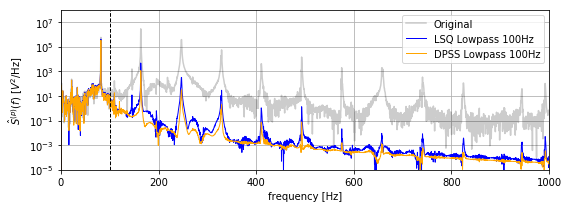

In [52]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.semilogy(f_E, Pxx_den_E_d, label='Original', c='k', alpha=0.2)
ax.semilogy(f_E_lsq1, Pxx_den_E_lsq1, label='LSQ Lowpass 100Hz', lw=1, c='Blue')
ax.semilogy(f_E_dpss1, Pxx_den_E_dpss1, label='DPSS Lowpass 100Hz', lw=1, c='Orange')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$\hat{S}^{(p)}(f)$ [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-5, 10**8)
ax.legend()
ax.grid()

ax.axvline(100, ls='--', color='k', lw=1)

fig.tight_layout()
plt.savefig('plots/filtering/DPSS_LSQ_100.png', dpi=200)
plt.show()

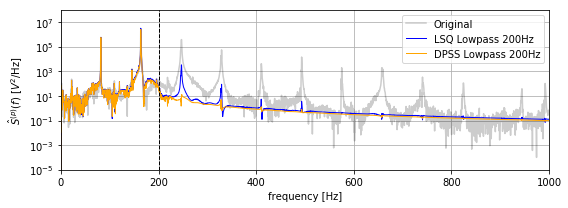

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.semilogy(f_E, Pxx_den_E_d, label='Original', c='k', alpha=0.2)
ax.semilogy(f_E_lsq2, Pxx_den_E_lsq2, label='LSQ Lowpass 200Hz', lw=1, c='Blue')
ax.semilogy(f_E_dpss2, Pxx_den_E_dpss2, label='DPSS Lowpass 200Hz', lw=1, c='Orange')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$\hat{S}^{(p)}(f)$ [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-5, 10**8)
ax.legend()
ax.grid()

ax.axvline(200, ls='--', color='k', lw=1)

fig.tight_layout()
plt.savefig('plots/filtering/DPSS_LSQ_200.png', dpi=200)
plt.show()

Note that the **side lobe** behaviour is better but the freqnuecy directly after the cutoff isnt filtered as well (**broadband**).